In [25]:
# imports & load
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

In [26]:
from google.colab import files
uploaded = files.upload()

# To read a CSV file:
import pandas as pd
df = pd.read_csv(next(iter(uploaded)))
df.head()
print("Shape:", df.shape)

Saving data.csv to data.csv
Shape: (1020, 10)


In [27]:
# quick overview
print("Columns:", df.columns.tolist())
print("\nData types:")
print(df.dtypes)
print("\nNon-null counts:")
print(df.notnull().sum())
print("\nDuplicate rows:", df.duplicated().sum())

Columns: ['Unnamed: 0', 'name', 'price', 'sim', 'processor', 'memory', 'baterry', 'display', 'camara', 'version']

Data types:
Unnamed: 0     int64
name          object
price         object
sim           object
processor     object
memory        object
baterry       object
display       object
camara        object
version       object
dtype: object

Non-null counts:
Unnamed: 0    1020
name          1020
price         1020
sim           1020
processor     1020
memory        1020
baterry       1020
display       1020
camara        1020
version       1019
dtype: int64

Duplicate rows: 0


In [28]:
# helpers for cleaning & feature extraction
def clean_price(x):
    if pd.isna(x): return np.nan
    s = re.sub(r'[^\d]', '', str(x))
    return int(s) if s != '' else np.nan

def extract_ram_storage(s):
    if pd.isna(s): return (np.nan, np.nan)
    nums = re.findall(r'(\d+)\s*GB', str(s), flags=re.I)
    if len(nums) >= 2:
        return (int(nums[0]), int(nums[1]))
    elif len(nums) == 1:
        if 'ram' in str(s).lower():
            return (int(nums[0]), np.nan)
        else:
            return (np.nan, int(nums[0]))
    else:
        nums2 = re.findall(r'(\d+)', str(s))
        if len(nums2) >= 2:
            return (int(nums2[0]), int(nums2[1]))
        elif len(nums2)==1:
            return (np.nan, int(nums2[0]))
        else:
            return (np.nan, np.nan)

def extract_battery(s):
    if pd.isna(s): return np.nan
    m = re.search(r'(\d{3,5})', str(s))
    return int(m.group(1)) if m else np.nan

def extract_display(s):
    if pd.isna(s): return np.nan
    m = re.search(r'(\d+\.\d+|\d+)\s*(?:inch|inches|in)', str(s), flags=re.I)
    if m:
        return float(m.group(1))
    m2 = re.search(r'(\d+\.\d+)', str(s))
    return float(m2.group(1)) if m2 else np.nan

def extract_camera_main(s):
    if pd.isna(s): return np.nan
    nums = re.findall(r'(\d{1,3})\s*\?*MP', str(s), flags=re.I)
    if len(nums) >= 1:
        return int(nums[0])
    return np.nan

def extract_camera_front(s):
    if pd.isna(s): return np.nan
    m = re.search(r'(\d{1,3})\s*\?*MP\s*Front', str(s), flags=re.I)
    if m:
        return int(m.group(1))
    nums = re.findall(r'(\d{1,3})\s*\?*MP', str(s), flags=re.I)
    if len(nums) >= 1:
        return int(nums[-1])
    return np.nan

def proc_brand(s):
    s = str(s).lower()
    if 'snapdragon' in s or 'qualcomm' in s:
        return 'Qualcomm'
    if 'mediatek' in s or 'dimensity' in s:
        return 'MediaTek'
    if 'exynos' in s:
        return 'Exynos'
    if 'apple' in s:
        return 'Apple'
    if 'kirin' in s:
        return 'Kirin'
    return 'Other'

def os_type(s):
    s = str(s).lower()
    if 'android' in s:
        return 'Android'
    if 'ios' in s:
        return 'iOS'
    return 'Other'

In [29]:
# apply cleaning & feature extraction
df['price_clean'] = df['price'].apply(clean_price)
df['brand'] = df['name'].apply(lambda x: str(x).split()[0])
df[['ram_gb','storage_gb']] = df['memory'].apply(lambda x: pd.Series(extract_ram_storage(x)))
df['battery_mah'] = df['baterry'].apply(extract_battery)  # note column name is 'baterry' in dataset
df['display_inch'] = df['display'].apply(extract_display)
df['cam_main_mp'] = df['camara'].apply(extract_camera_main)
df['cam_front_mp'] = df['camara'].apply(extract_camera_front)
df['processor_brand'] = df['processor'].apply(proc_brand)
df['os_type'] = df['version'].apply(os_type)
df['price_log'] = df['price_clean'].apply(lambda x: np.log(x) if pd.notna(x) and x>0 else np.nan)

# quick view
df[['name','price','price_clean','brand','ram_gb','storage_gb','battery_mah','display_inch','cam_main_mp','processor_brand','os_type']].head(10)

,name,price,price_clean,brand,ram_gb,storage_gb,battery_mah,display_inch,cam_main_mp,processor_brand,os_type
0,OnePlus Nord CE 2 Lite 5G,"?18,999",18999,OnePlus,6.0,128.0,5000.0,6.59,64.0,Qualcomm,Android
1,Samsung Galaxy A14 5G,"?16,499",16499,Samsung,4.0,64.0,5000.0,6.60,50.0,Exynos,Android
2,Samsung Galaxy F23 5G (6GB RAM + 128GB),"?16,999",16999,Samsung,6.0,128.0,5000.0,6.60,50.0,Qualcomm,Android
3,Motorola Moto G62 5G,"?14,999",14999,Motorola,6.0,128.0,5000.0,6.55,50.0,Qualcomm,Android
4,Realme 10 Pro Plus,"?24,999",24999,Realme,6.0,128.0,5000.0,6.70,108.0,MediaTek,Android
5,Apple iPhone 14,"?66,999",66999,Apple,6.0,128.0,3279.0,6.10,12.0,Other,iOS
6,Xiaomi Redmi Note 12 Pro Plus,"?29,999",29999,Xiaomi,8.0,256.0,4980.0,6.67,200.0,MediaTek,Android
7,Oppo A78,"?18,999",18999,Oppo,8.0,128.0,5000.0,6.56,50.0,MediaTek,Android
8,OnePlus Nord 2T 5G,"?28,900",28900,OnePlus,8.0,128.0,4500.0,6.43,50.0,MediaTek,Other
9,Samsung Galaxy A23,"?18,499",18499,Samsung,6.0,128.0,5000.0,6.60,50.0,Qualcomm,Android


In [32]:
# missingness & descriptive stats
print("Missing counts for key new features:")
print(df[['price_clean','ram_gb','storage_gb','battery_mah','display_inch','cam_main_mp']].isnull().sum())

print("\nPrice (clean) descriptive stats:")
print(df['price_clean'].describe())

print(df[['price_clean','brand','ram_gb','storage_gb','battery_mah','display_inch','cam_main_mp']].head(200).to_csv('/content/cleaned_sample_200.csv', index=False))

Missing counts for key new features:
price_clean       0
ram_gb           65
storage_gb       14
battery_mah      22
display_inch     56
cam_main_mp     102
dtype: int64

Price (clean) descriptive stats:
count      1020.000000
mean      21362.683333
std       27031.620107
min         599.000000
25%        8149.000000
50%       13499.000000
75%       23301.500000
max      239999.000000
Name: price_clean, dtype: float64
None


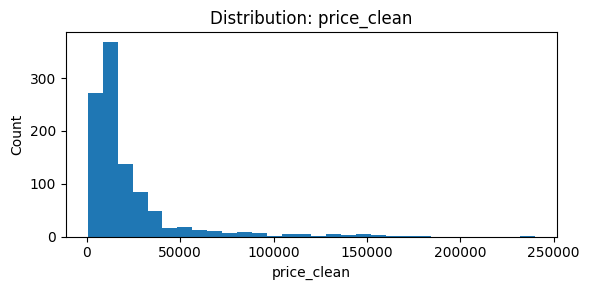

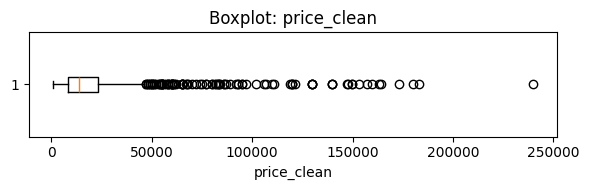

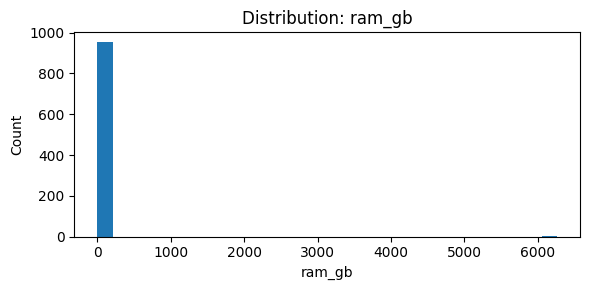

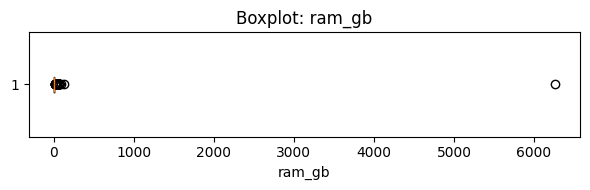

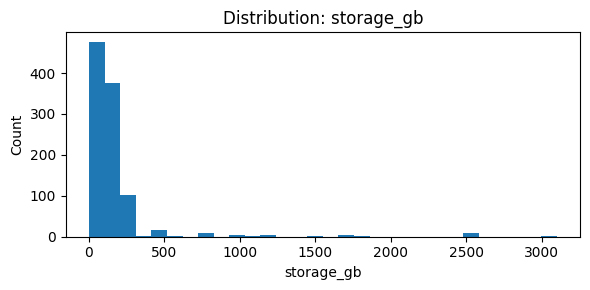

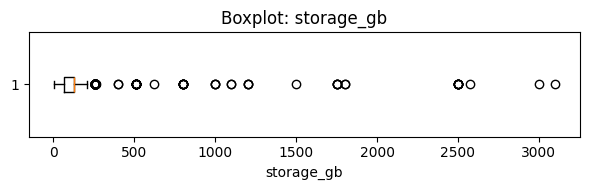

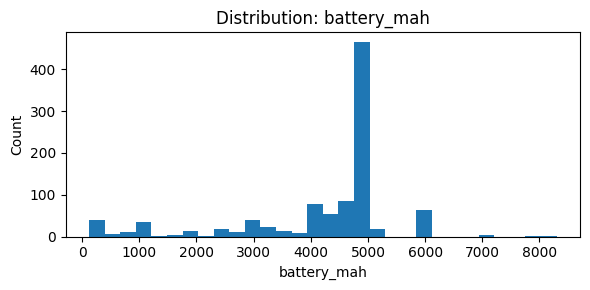

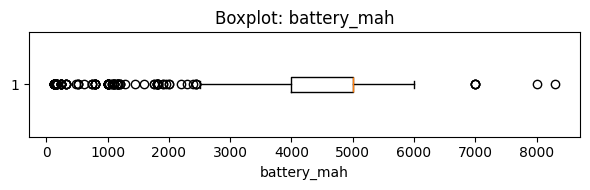

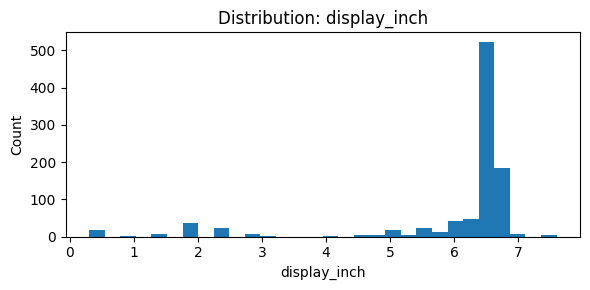

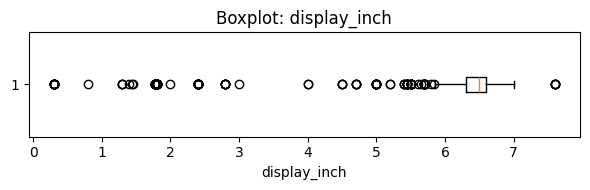

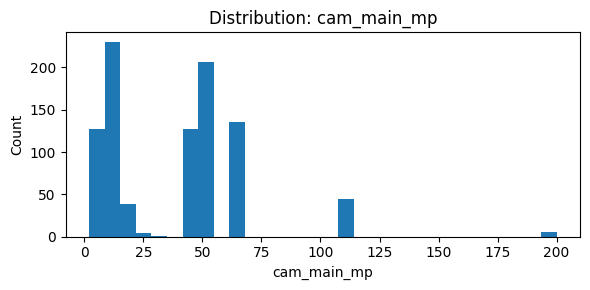

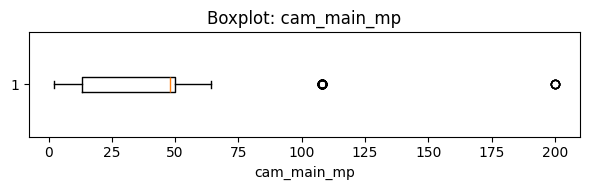

In [33]:
# histograms and boxplots for price and other numeric features
numeric_cols = ['price_clean','ram_gb','storage_gb','battery_mah','display_inch','cam_main_mp']
for col in numeric_cols:
    plt.figure(figsize=(6,3))
    plt.hist(df[col].dropna(), bins=30)
    plt.title(f'Distribution: {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6,2))
    plt.boxplot(df[col].dropna(), vert=False)
    plt.title(f'Boxplot: {col}')
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

Correlation matrix:
              price_clean    ram_gb  storage_gb  battery_mah  display_inch  \
price_clean      1.000000 -0.027467    0.055412     0.051712      0.273576   
ram_gb          -0.027467  1.000000    0.059864    -0.482116     -0.700264   
storage_gb       0.055412  0.059864    1.000000    -0.440019     -0.439232   
battery_mah      0.051712 -0.482116   -0.440019     1.000000      0.866769   
display_inch     0.273576 -0.700264   -0.439232     0.866769      1.000000   
cam_main_mp      0.215343 -0.094451    0.441766     0.389807      0.423765   

              cam_main_mp  
price_clean      0.215343  
ram_gb          -0.094451  
storage_gb       0.441766  
battery_mah      0.389807  
display_inch     0.423765  
cam_main_mp      1.000000  


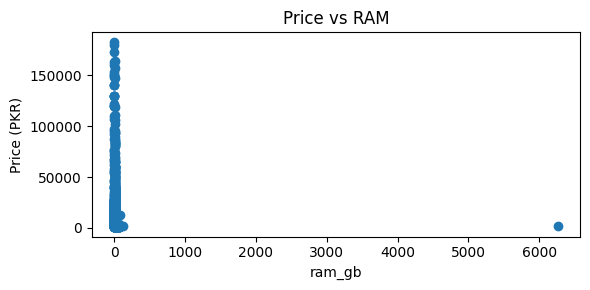

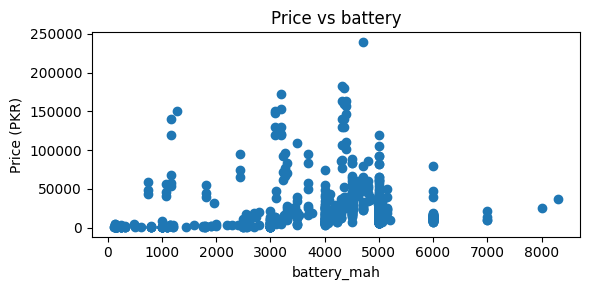

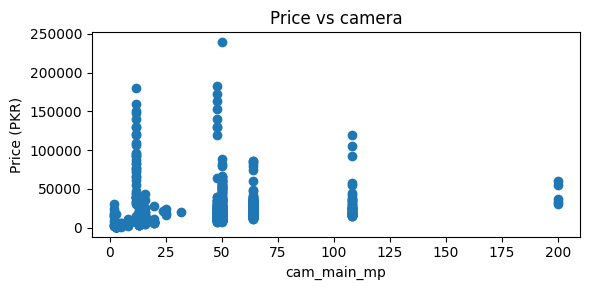

/tmp/ipython-input-143164426.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=top_brands, vert=False)


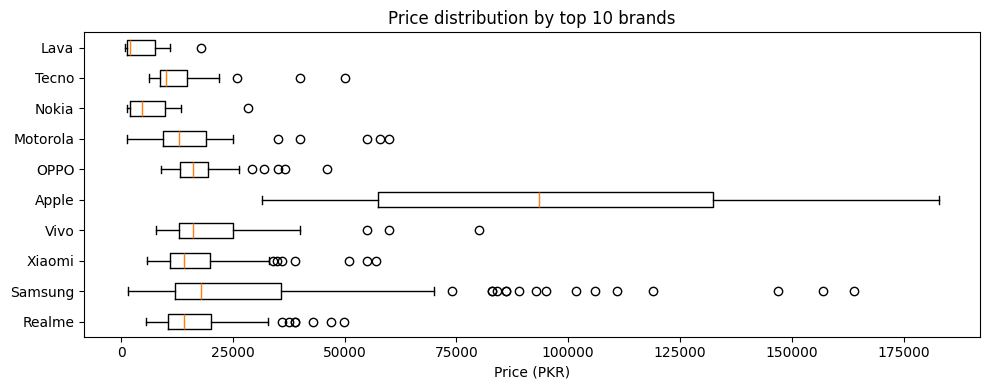

In [34]:
# correlation and basic scatter plots with price
print("Correlation matrix:")
print(df[numeric_cols].corr())

pairs = [('ram_gb','Price vs RAM'), ('battery_mah','Price vs battery'), ('cam_main_mp','Price vs camera')]
for col,label in pairs:
    plt.figure(figsize=(6,3))
    plt.scatter(df[col], df['price_clean'])
    plt.xlabel(col)
    plt.ylabel('Price (PKR)')
    plt.title(label)
    plt.tight_layout()
    plt.show()

# Price by top brands
top_brands = df['brand'].value_counts().nlargest(10).index.tolist()
df_box = df[df['brand'].isin(top_brands)]
groups = [df_box[df_box['brand']==b]['price_clean'].dropna() for b in top_brands]
plt.figure(figsize=(10,4))
plt.boxplot(groups, labels=top_brands, vert=False)
plt.title('Price distribution by top 10 brands')
plt.xlabel('Price (PKR)')
plt.tight_layout()
plt.show()